In [3]:
!pip install pandasql


In [4]:
import sqlalchemy as sql
import psycopg2 
import pandas.io.sql as sqlio
import pandas as pd
from functools import reduce
import sqlalchemy
import seaborn as sns
import matplotlib.pyplot as plt
from pandasql import sqldf

In [5]:
engine = sqlalchemy.create_engine('insert_url')

In [6]:
query = """
with equity_avg as (
select account_number , percentile_cont(0.5) within group (order by avg_equity) as median_equity
from (
select account_number, sum(max_equity_month)/count(month_of) as avg_equity
from (
select a.account_number,date_trunc('month', asof) as month_of, max(db.equity) as max_equity_month
from net_balance db 
left join accounts A on a.id = db.account_id
where a.account_type in ('type_a', '', 'NULL')
and asof between '2021-05-01' and '2021-06-01'
and db.equity > 0
and a.account_number is not NULL
group by 1, 2
)query1
group by 1
)query2
group by 1
),

mean_orders as (
select orders.account,  count(orders.id)/count(distinct date_trunc('day', filled_at)) as orders_per_day
from orders 
left join accounts A on a.account_number = orders.account 
left join assets ast ON ast.id::uuid=orders.asset_id::uuid
where filled_at::date between '2021-05-01' and '2021-06-01'
and filled_at is not NULL
and ast.class = 'us_equity'
and orders.account not in ('NULL', '', 'NOHODL')
and account_type in ('type_a', '', 'NULL')
group by 1

),

order_list as (

select * 
from orders_table
),


cte1 as (
select * 
from order_list

),



final_data as (
select
account_number,
sum(qty*rebate_amount) as tot_rebates
from cte1

group by 1),

final_segmentation as (

select mo.account, fd.tot_rebates,
case when orders_per_day < 5 and median_equity < 25000 then 'LOW AUM LOW FREQ'  
     when (orders_per_day between 5 and 100) and median_equity < 25000 then 'LOW AUM MED FREQ'
     when orders_per_day > 100 and median_equity < 25000 then 'LOW AUM HIGH FREQ'
     when orders_per_day < 5 and (median_equity between 25000 and 250000) then 'MED AUM LOW FREQ'
     when (orders_per_day between 5 and 100) and (median_equity between 25000 and 250000) then 'MED AUM MED FREQ'
     when orders_per_day > 100 and (median_equity between 25000 and 250000) then 'MED AUM HIGH FREQ'
     when orders_per_day < 5 and median_equity >250000 then 'HIGH AUM LOW FREQ'
     when (orders_per_day between 5 and 100) and median_equity >250000 then 'HIGH AUM MED FREQ'
     when orders_per_day > 100 and median_equity >250000 then 'HIGH AUM HIGH FREQ'
     else 'other' end as data_group
     
from mean_orders mo
left join equity_avg ea on ea.account_number = mo.account 
left join final_data fd on fd.account_number = mo.account)



select count(distinct account) as total_accounts ,  sum(tot_rebates) as total_revenue, data_group
from final_segmentation
group by 3


"""

In [7]:
df = pd.read_sql_query(query, engine)

In [38]:
df['revenue_account'] = df['total_revenue']/df['total_accounts']

In [39]:
df = df.sort_values(by='total_revenue', ascending = False)

In [40]:
total_df = df[['data_group', 'total_revenue', 'revenue_account']]

In [41]:
total_df = total_df.rename(columns={"total_revenue":"may_revenue", "revenue_account":"may_revenue_account"})

In [42]:
total_df

,data_group,may_revenue,may_revenue_account
6,MED AUM HIGH FREQ,84660.603200,1511.796486
8,MED AUM MED FREQ,55713.237750,227.400970
2,HIGH AUM MED FREQ,27643.098825,1727.693677
7,MED AUM LOW FREQ,11944.967650,48.954785
5,LOW AUM MED FREQ,4101.102225,20.103442
4,LOW AUM LOW FREQ,3571.545150,4.532418
1,HIGH AUM LOW FREQ,489.206800,48.920680
9,other,271.522000,135.761000
3,LOW AUM HIGH FREQ,-486.541275,-60.817659
0,HIGH AUM HIGH FREQ,-2650.182025,-331.272753


In [14]:
df2 = pd.read_sql_query(query2, engine)

In [43]:
df2['revenue_account'] = df2['total_revenue']/df2['total_accounts']

In [44]:
total_df = total_df.merge(df2[['data_group','total_revenue', 'revenue_account']], on='data_group', how='left')
total_df = total_df.rename(columns={"total_revenue":"april_revenue", "revenue_account":"april_revenue_account"})

In [18]:
df3 = pd.read_sql_query(query3, engine)

In [46]:
df3['revenue_account'] = df3['total_revenue']/df3['total_accounts']

In [47]:
total_df = total_df.merge(df3[['data_group','total_revenue', 'revenue_account']], on='data_group', how='left')
total_df = total_df.rename(columns={"total_revenue":"march_revenue", "revenue_account":"march_revenue_account"})

In [22]:
df4 = pd.read_sql_query(query4, engine)

In [48]:
df4['revenue_account'] = df4['total_revenue']/df4['total_accounts']

In [49]:
total_df = total_df.merge(df4[['data_group','total_revenue', 'revenue_account']], on='data_group', how='left')
total_df = total_df.rename(columns={"total_revenue":"february_revenue", "revenue_account":"february_revenue_account"})

In [34]:
df0 = pd.read_sql_query(query0, engine)

In [50]:
df0['revenue_account'] = df0['total_revenue']/df0['total_accounts']

In [51]:
total_df = total_df.merge(df0[['data_group','total_revenue', 'revenue_account']], on='data_group', how='left')
total_df = total_df.rename(columns={"total_revenue":"june_revenue", "revenue_account":"june_revenue_account"})

In [52]:
total_df

,data_group,may_revenue,may_revenue_account,april_revenue,april_revenue_account,march_revenue,march_revenue_account,february_revenue,february_revenue_account,june_revenue,june_revenue_account
0,MED AUM HIGH FREQ,84660.603200,1511.796486,80516.039750,1548.385380,33424.593475,726.621597,13272.925325,282.402666,44501.544025,635.736343
1,MED AUM MED FREQ,55713.237750,227.400970,66928.635500,240.750487,88629.829175,299.425099,110609.168075,343.506733,67514.472710,253.813807
2,HIGH AUM MED FREQ,27643.098825,1727.693677,35599.653875,2373.310258,41318.368525,2754.557902,21729.885575,1448.659038,12858.662625,714.370146
3,MED AUM LOW FREQ,11944.967650,48.954785,9141.988100,37.012098,7489.238575,32.420946,4659.644350,21.774039,5132.903925,21.298357
4,LOW AUM MED FREQ,4101.102225,20.103442,1094.097225,6.435866,8633.970800,38.373204,8366.187125,35.004967,2410.583495,13.853928
5,LOW AUM LOW FREQ,3571.545150,4.532418,3740.463700,4.777093,7361.523375,7.589199,4377.478250,3.573452,2488.507925,2.958987
6,HIGH AUM LOW FREQ,489.206800,48.920680,625.464000,52.122000,373.064000,37.306400,785.964000,65.497000,180.954800,18.095480
7,other,271.522000,135.761000,321.081200,107.027067,7.371200,1.228533,2.154000,1.077000,202.440000,101.220000
8,LOW AUM HIGH FREQ,-486.541275,-60.817659,254.879475,50.975895,1859.898100,265.699729,760.865825,190.216456,219.918530,109.959265
9,HIGH AUM HIGH FREQ,-2650.182025,-331.272753,-2220.110300,-222.011030,21086.472300,2635.809038,44056.564950,6293.794993,1727.670600,172.767060


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'MED AUM HIGH FREQ'),
  Text(1, 0, 'MED AUM MED FREQ'),
  Text(2, 0, 'HIGH AUM MED FREQ'),
  Text(3, 0, 'MED AUM LOW FREQ'),
  Text(4, 0, 'LOW AUM MED FREQ'),
  Text(5, 0, 'LOW AUM LOW FREQ'),
  Text(6, 0, 'HIGH AUM LOW FREQ'),
  Text(7, 0, 'other'),
  Text(8, 0, 'LOW AUM HIGH FREQ'),
  Text(9, 0, 'HIGH AUM HIGH FREQ')])

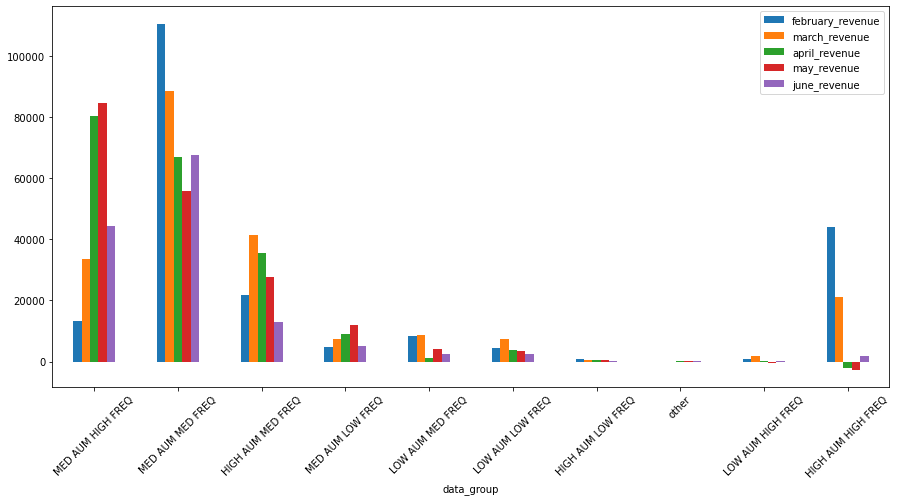

In [53]:
total_df.plot(x='data_group', y = ['february_revenue','march_revenue', 'april_revenue', 'may_revenue', 'june_revenue'],
        kind='bar',
        stacked=False,
         figsize=(15,7) )
plt.xticks(rotation = 45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'MED AUM HIGH FREQ'),
  Text(1, 0, 'MED AUM MED FREQ'),
  Text(2, 0, 'HIGH AUM MED FREQ'),
  Text(3, 0, 'MED AUM LOW FREQ'),
  Text(4, 0, 'LOW AUM MED FREQ'),
  Text(5, 0, 'LOW AUM LOW FREQ'),
  Text(6, 0, 'HIGH AUM LOW FREQ'),
  Text(7, 0, 'other'),
  Text(8, 0, 'LOW AUM HIGH FREQ'),
  Text(9, 0, 'HIGH AUM HIGH FREQ')])

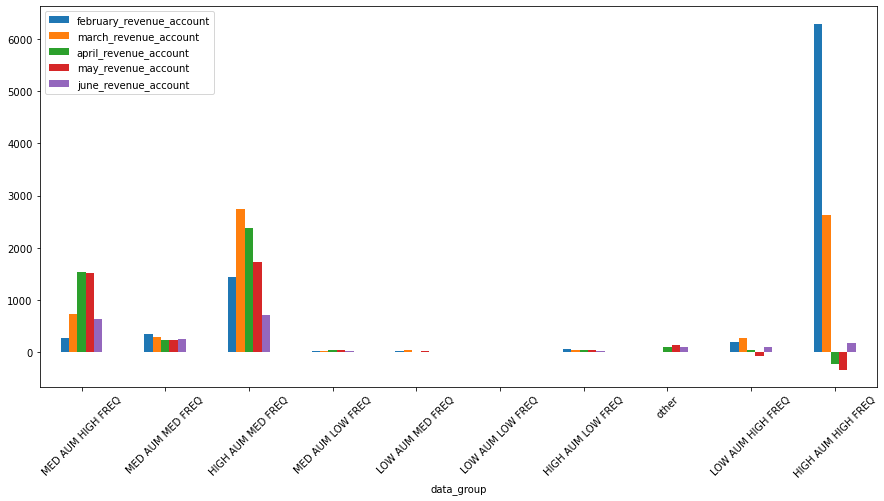

In [54]:
total_df.plot(x='data_group', y = ['february_revenue_account','march_revenue_account', 'april_revenue_account', 'may_revenue_account', 'june_revenue_account'],
        kind='bar',
        stacked=False,
         figsize=(15,7) )
plt.xticks(rotation = 45)

In [55]:
total_df.to_csv('trading_2021.csv')